# Import Library

In [1]:
import torch
import wandb
import numpy as np
import pandas as pd
import re
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast  

from collections import defaultdict
warnings.filterwarnings("ignore")

# Cleaning Data

In [2]:
#Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

duplicates = df.duplicated(['question'], keep=False).sum()
print(f"Total duplicates in 'question' column: {duplicates}")

# Check for duplicate rows

duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['source', 'focus_area'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df.dropna(inplace=True)

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Checking again of the data info
print(df.info())

#Check for Unique Data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
print(df.head())

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Total duplicates in 'question' column: 2319
Number of duplicate rows: 48
Table Info
<class 

# Architecting Model

In [ ]:
# Load T5-small model and tokenizer
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.3
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Print model architecture summary
def print_model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\nModel Summary:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

print_model_summary(model)

# Preprocess function for seq2seq task
def preprocess_function(batch):
    inputs = [
        f"answer this question: {q} context: {c if 'context' in batch else ''} </s>"
        for q, c in zip(batch["question"], batch.get("context", [""] * len(batch["question"])))
    ]
    targets = [f"{a} </s>" for a in batch["answer"]]

    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="longest",
        return_tensors="pt",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,
            truncation=True,
            padding="longest",
            return_tensors="pt",
        )

    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Preprocess datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=1000,  
    remove_columns=train_dataset.column_names,
    num_proc=8,   
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=1000,  
    remove_columns=val_dataset.column_names,
    num_proc=8,  
)


# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,  
    save_steps=500,  
    save_total_limit=2,  
    learning_rate=1e-4,   
    num_train_epochs=10,   
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16, 
    lr_scheduler_type="cosine",  
    warmup_ratio=0.05,  
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=True,   
    logging_dir="./logs",
    logging_steps=50,  
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,   
    max_grad_norm=1.0,
    optim="adamw_torch_fused",  
    generation_max_length=64,  
    generation_num_beams=5,
    dataloader_num_workers=4,   
    group_by_length=True, 
    remove_unused_columns=True,
)

training_args.label_smoothing_factor = 0.1
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,  
    padding=True,  
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Handle padding and special tokens
    predictions = np.where(predictions == -100, tokenizer.pad_token_id, predictions)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean and normalize text
    def clean_text(text):
        text = " ".join(text.strip().lower().split())
        return text
    
    decoded_preds = [clean_text(pred) for pred in decoded_preds]
    decoded_labels = [clean_text(label) for label in decoded_labels]
    
    # Exact match accuracy
    exact_matches = [pred == label for pred, label in zip(decoded_preds, decoded_labels)]
    exact_match_accuracy = np.mean(exact_matches) * 100
    
    # Word-level accuracy
    def calculate_word_accuracy(pred, label):
        pred_words = set(pred.split())
        label_words = set(label.split())
        if len(label_words) == 0:
            return 0.0
        return len(pred_words.intersection(label_words)) / len(label_words)
    
    word_accuracies = [calculate_word_accuracy(pred, label) 
                       for pred, label in zip(decoded_preds, decoded_labels)]
    word_level_accuracy = np.mean(word_accuracies) * 100
    
    # Metrics dictionary
    metrics = {
        "accuracy": exact_match_accuracy,  
        "validation_accuracy": word_level_accuracy,  
    }
    
    # Log examples for debugging
    if len(decoded_preds) > 0:
        n_samples = min(3, len(decoded_preds))
        for i in range(n_samples):
            metrics[f"example_{i+1}_pred"] = decoded_preds[i][:100]
            metrics[f"example_{i+1}_true"] = decoded_labels[i][:100]
            metrics[f"example_{i+1}_exact_match"] = exact_matches[i]
            metrics[f"example_{i+1}_word_accuracy"] = word_accuracies[i]
    
    return metrics

# Initialize data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    return_tensors="pt"
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save log history
log_history = trainer.state.log_history



Model Summary:
Total parameters: 222,903,552
Trainable parameters: 222,903,552


Map (num_proc=8):   0%|          | 0/13016 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1447 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Validation Accuracy,Example 1 Pred,Example 1 True,Example 1 Exact Match,Example 1 Word Accuracy,Example 2 Pred,Example 2 True,Example 2 Exact Match,Example 2 Word Accuracy,Example 3 Pred,Example 3 True,Example 3 Exact Match,Example 3 Word Accuracy
500,1.583600,1.536552,13.614375,39.827076,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,True,1.000000,phosphoglycerate kinase deficiency (pgk) is a condition that affects the body's ability to make phos,phosphoglycerate kinase deficiency is a genetic disorder that affects the body's ability to break do,False,0.297297,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,False,0.708333
1000,1.481800,1.471173,13.752592,40.596241,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,True,1.000000,phosphoglycerate kinase (pgk) deficiency is an inherited disorder that affects many parts of the bod,phosphoglycerate kinase deficiency is a genetic disorder that affects the body's ability to break do,False,0.243243,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,False,0.708333
1500,1.407200,1.437764,14.029026,41.301016,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,True,1.000000,phosphoglycerate kinase deficiency is an inherited disorder that affects many parts of the body. the,phosphoglycerate kinase deficiency is a genetic disorder that affects the body's ability to break do,False,0.297297,these resources address the diagnosis or management of beta thalassemia: - genetic testing registry:,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,False,0.625000
2000,1.344800,1.434468,14.029026,41.346232,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,what are the signs and symptoms of charcot-marie-tooth disease type 2b? the human phenotype ontology,True,1.000000,phosphoglycerate kinase (pgk) deficiency is an inherited disorder that affects the body's ability to,phosphoglycerate kinase deficiency is a genetic disorder that affects the body's ability to break do,False,0.378378,these resources address the diagnosis or management of beta thalassemia: - genetic testing registry:,these resources address the diagnosis or management of beta thalassemia: - gene review: gene review:,False,0.625000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


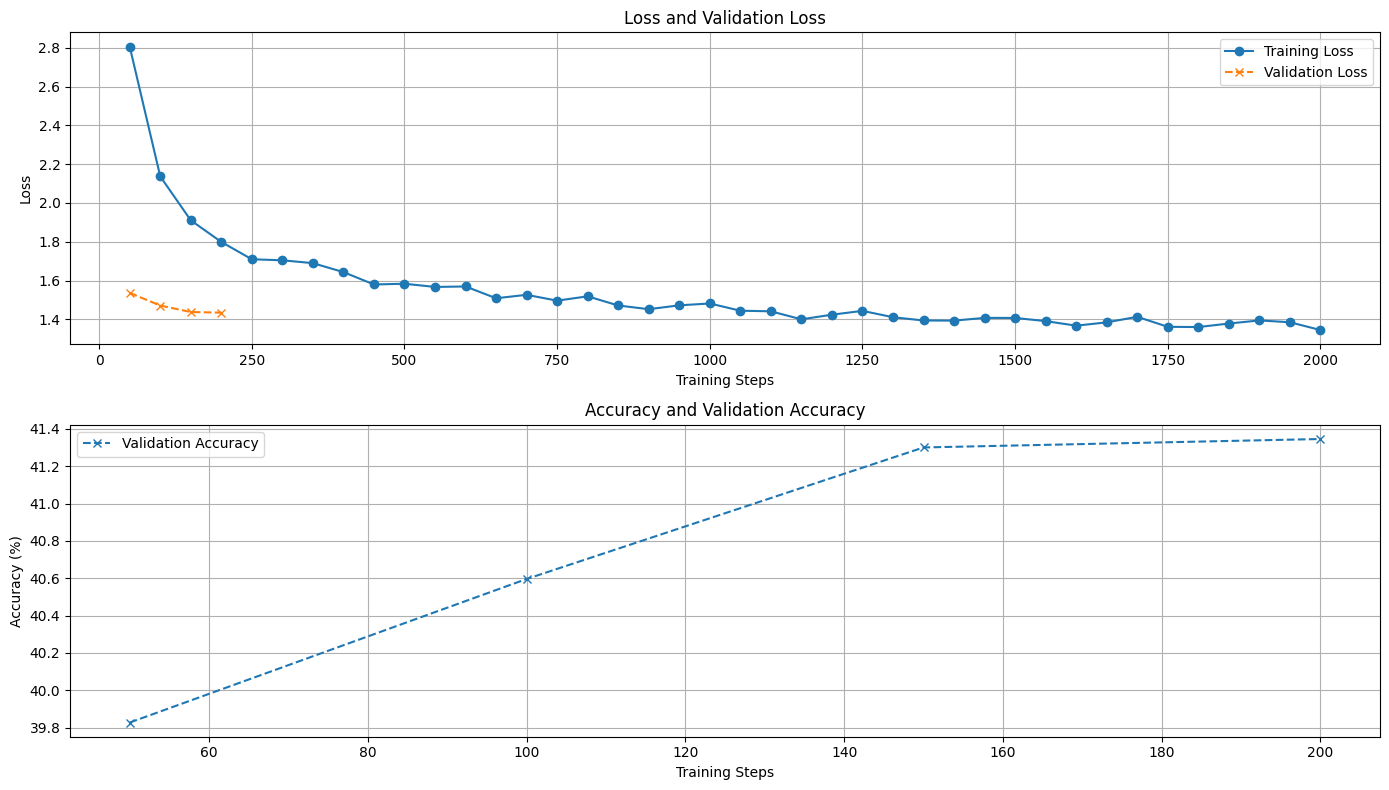

In [ ]:
steps = []
training_loss = []
validation_loss = []
accuracy = []
validation_accuracy = []
# print(log_history)

# Parse log history to extract relevant metrics
for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        training_loss.append(entry["loss"])
    if "eval_loss" in entry:
        validation_loss.append(entry["eval_loss"])
    if "accuracy" in entry:
        accuracy.append(entry["accuracy"])
    if "eval_validation_accuracy" in entry:
        validation_accuracy.append(entry["eval_validation_accuracy"])

# Plot metrics
plt.figure(figsize=(14, 8))

# Subplot 1: Loss vs Validation Loss
plt.subplot(2, 1, 1)
plt.plot(steps[:len(training_loss)], training_loss, label="Training Loss", marker="o", linestyle="-")
if validation_loss:
    plt.plot(steps[:len(validation_loss)], validation_loss, label="Validation Loss", marker="x", linestyle="--")
plt.title("Loss and Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy vs Validation Accuracy
plt.subplot(2, 1, 2)
if accuracy:
    plt.plot(steps[:len(accuracy)], accuracy, label="Training Accuracy", marker="o", linestyle="-")
if validation_accuracy:
    plt.plot(steps[:len(validation_accuracy)], validation_accuracy, label="Validation Accuracy", marker="x", linestyle="--")
plt.title("Accuracy and Validation Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Testing using Input

In [12]:
# Load the trained T5 model and tokenizer
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval() 

def generate_response(question):
    input_ids = tokenizer(f"question: {question} </s>", return_tensors="pt").input_ids.to(model.device)
    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=5,  
        no_repeat_ngram_size=2,  
        top_k=50,  
        top_p=0.95,  
        temperature=1.0  
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
response = generate_response("What is glaucoma ?")
print(response)

glaucoma is a condition that affects the eyes. it is caused by mutations in the gln gene, which is responsible for many of the most common eye diseases. people with this condition have an increased risk of developing cataracts.
